In [31]:
from pymoo.problems.single.traveling_salesman import TravelingSalesman
from pymoo.core.problem import ElementwiseProblem

In [12]:
import numpy as np
dist_central = np.loadtxt("CustDist_WHCentral.csv", skiprows=1, delimiter=",")[:,1:]
xy_central   = np.loadtxt("CustXY_WHCentral.csv", skiprows=1, delimiter=",")[:,1:].T

orders       = np.loadtxt("CustOrd.csv", skiprows=1, delimiter=",")[:,1]

In [117]:
class TravelingSalesman(ElementwiseProblem):

    def __init__(self, distances, orders, n_cities, coords, **kwargs):
        """
        A two-dimensional traveling salesman problem (TSP)

        Parameters
        ----------
        cities : numpy.array
            The cities with 2-dimensional coordinates provided by a matrix where where city is represented by a row.

        """
        self.n_cities = n_cities
        self.cities=coords

        self.D = distances
        self.O = orders

        super(TravelingSalesman, self).__init__(
            n_var=n_cities,
            n_obj=2,
            xl=1,
            xu=n_cities+1,
            vtype=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out['F'] = self.evaluateMO(x, self.D, self.O)

    def evaluateMO(self, individual, distances, orders, max_capacity=1000):
        dist = distances[0, individual[0]]
        cost = max_capacity*dist
        capacity = max_capacity - orders[individual[0]]

        for i, f in zip(individual[:-1], individual[1:]):
            if capacity < orders[f]:
                cost += capacity*distances[i][0]
                dist += distances[i][0]
                capacity = max_capacity
                cost += capacity*distances[0][f]
                dist += distances[0][f]
                # print("Ups, go back")
            else:
                cost += capacity*distances[i][f]
                dist += distances[i][f]

            capacity -= orders[f]
            # print(f"Went from {i} to {f} and capacity is now {capacity} and dist is {dist}")        
        cost+=capacity*distances[0,individual[-1]]
        dist+=distances[0,individual[-1]]
        return (dist,cost/1000)

In [124]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.pcx import PCX
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.operators.selection.tournament import TournamentSelection

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=50,
    sampling=PermutationRandomSampling(),
    mutation=InversionMutation(),
    crossover=OrderCrossover(),
    eliminate_duplicates=False
)

In [128]:
from pymoo.termination import get_termination

termination = get_termination("n_evals", 100_000)

In [129]:
from pymoo.optimize import minimize

problem = TravelingSalesman(dist_central, orders,30 , xy_central)
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)

X = res.X
F = res.F

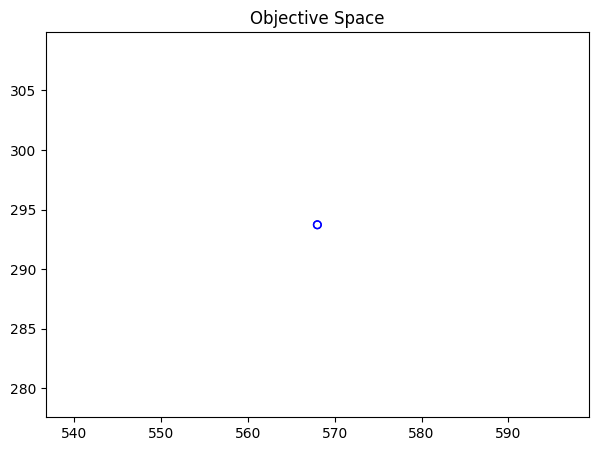

In [130]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [68]:
print("Traveling Time:", np.round(res.F[0], 3))

Traveling Time: 535.0


In [132]:
F

array([[568.  , 293.72],
       [568.  , 293.72]])